In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [29]:
df = pd.read_csv(r"C:\Users\thoma\Desktop\ev-modelling-repo\Rohdaten\NHTS_trips_processed.csv")

In [30]:
filt = df["Type_day"] < 6
df = df[filt]

## Reduzieren der Daten auf erste Wege des Tages
* Achtung: W_NR (Weg Nummer) scheinbar nicht explizit in MiD Studie -> Ermittlung dort auf andere Art und Weise

In [31]:
filt = df["Trip_no"] == 1
df = df[filt]
first_trip = df["Departure"]

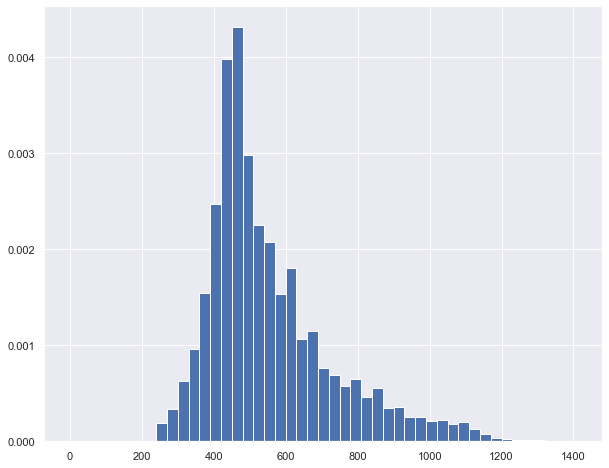

In [32]:
# Histogramm der Abfahrtszeiten der ersten Trips
sns.set()
plt.figure(figsize=(10,8))
count, bins, ignored = plt.hist(first_trip, bins=range(0, int(max(first_trip)), 30), density=True)

## Erstellen des Kernel Density Estimation Modells

In [33]:
from sklearn.neighbors import KernelDensity

In [34]:
x = np.linspace(-50, 1450, 1000)
model_data = np.array(first_trip)

In [35]:
# Erstellen Kernel Density Estimation Modell mit Bandbreite 25
kde_model = KernelDensity(bandwidth=19)
# Trainieren des Modells mit den Daten (np.newaxis transformiert den Reihen- zu Spaltenvektor) 
kde_model.fit(model_data[:, np.newaxis])
# übertragen in visaulisierbare Wahrscheinlichkeitsdichtefunktion
kde_log_pdf = kde_model.score_samples(x[:, np.newaxis])
kde_pdf = np.exp(kde_log_pdf)

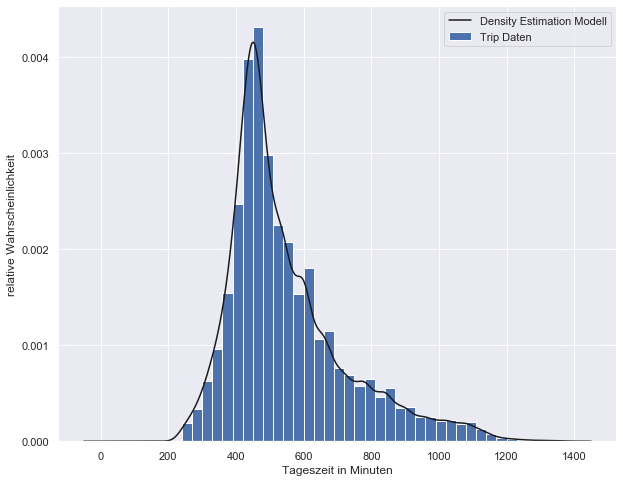

In [36]:
# Plottten des Modells
plt.figure(figsize=(10,8))
plt.hist(first_trip, bins=range(0, int(max(model_data)), 30), density=True);
plt.plot(x, kde_pdf, '-k');
labels = ["Density Estimation Modell", "Trip Daten"]
plt.legend(labels);
plt.xlabel("Tageszeit in Minuten");
plt.ylabel("relative Wahrscheinlichkeit");

In [37]:
# Optimierung der Bandweite -> lange Rechenzeit -> Optimierung erst bei Arbeit mit MiD Daten
"""from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(10, 20, 10)},
                    cv=5) # k-fold cross validation
grid.fit(model_data[:, None])
print(grid.best_params_)"""

"from sklearn.model_selection import GridSearchCV\ngrid = GridSearchCV(KernelDensity(),\n                    {'bandwidth': np.linspace(10, 20, 10)},\n                    cv=5) # k-fold cross validation\ngrid.fit(model_data[:, None])\nprint(grid.best_params_)"

## Testen des Modells

In [38]:
model_samples = kde_model.sample(len(model_data))

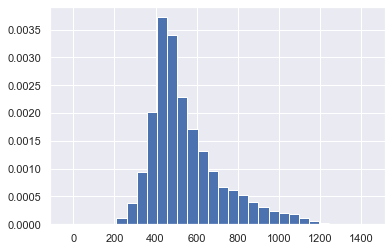

In [39]:
plt.figure();
plt.hist(model_samples, density=True, bins=30);

## Modell speichern

In [40]:
from pathlib import Path
import pickle
import os

root = os.getcwd()
if not os.path.exists(os.getcwd()+ "\\Simulationsdaten"):
    os.makedirs(root+"\\Simulationsdaten")

model_path = root+"\\Simulationsdaten"+"\\Modell_Initiale_Abfahrtszeit_Werktag.pickle"
hist_path = root+"\\Simulationsdaten"+"\\Liste_Initiale_Abfahrtszeit_Werktag.pickle"

pickle.dump(kde_model, open(model_path, "wb"))
pickle.dump(first_trip, open(hist_path, "wb"))

# Gaussian Mixture Model ermitteln (initiale Idee)

## Density Estimation scheint bessere Ergebnisse zu produzieren und über GridSearch besser optimierbar

from sklearn.mixture import GaussianMixture

model_data = np.array(first_trip)

gm_models = [None for i in range(15)]
model_data = np.array(first_trip).reshape(-1,1)
for i in range(1, 16):
    gm_models[i-1] = GaussianMixture(n_components=i, n_init=10).fit(model_data)
    

## Bestimme bestes Model anhand 'theoretical information criterion' 
* je kleiner desto besser
* Bestrafung komplexerer Systeme (mehr Komponenten)
* Belohnung besserer fit zu den Daten


AIC = [m.aic(model_data) for m in gm_models]
BIC = [m.bic(model_data) for m in gm_models]

m_best = gm_models[np.argmin(AIC)]

# Ergebnis plotten

* logprob = logarithmische Wahrscheinlichkeit der x-Werte 
* responsibilities = Anteil der individuellen Normalverteilungen an der Gesamtwahrscheinlichkeit

x = np.linspace(-50, 1450, 10000)
logprob = m_best.score_samples(x.reshape(-1, 1))
responsibilities = m_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(10,8))
plt.hist(first_trip, bins=52, density=True);
plt.plot(x, pdf, '-k');
plt.plot(x, pdf_individual, '--k', alpha=0.7);
labels = ["Aggregiertes GMM", "Individuelle Normalverteilungen"]
plt.legend(labels)
plt.xlabel("Tageszeit in Minuten")
plt.ylabel("relative Wahrscheinlichkeit")